In [2]:
# %pip install pandas numpy matplotlib
# %pip install -U scikit-learn
# %pip install Jinja2

# Imports

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

# Dataset exploration

Analisy the dataset structure and features

In [2]:
dataset = pd.read_csv('../data/bmw.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB


- model: BMW model
- year: registration year
- price: price in £
- transmission: type of gearbox
- mileage: miles travelled
- fuelType: engine fuel
- tax: road tax (£)
- mpg: miles per gallon
- engineSize: in (L)

In [3]:
dataset.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


Create histograms and boxplots to identify distributions and outliers

To do that, we need to select features that have a range of values, such as "price", "mileage", "tax", "mpg", and "year".

The other features are categorical and won't provide meaningful insights through histograms or boxplots, even the "engineSize" that has a *float64* type but only a few unique values.

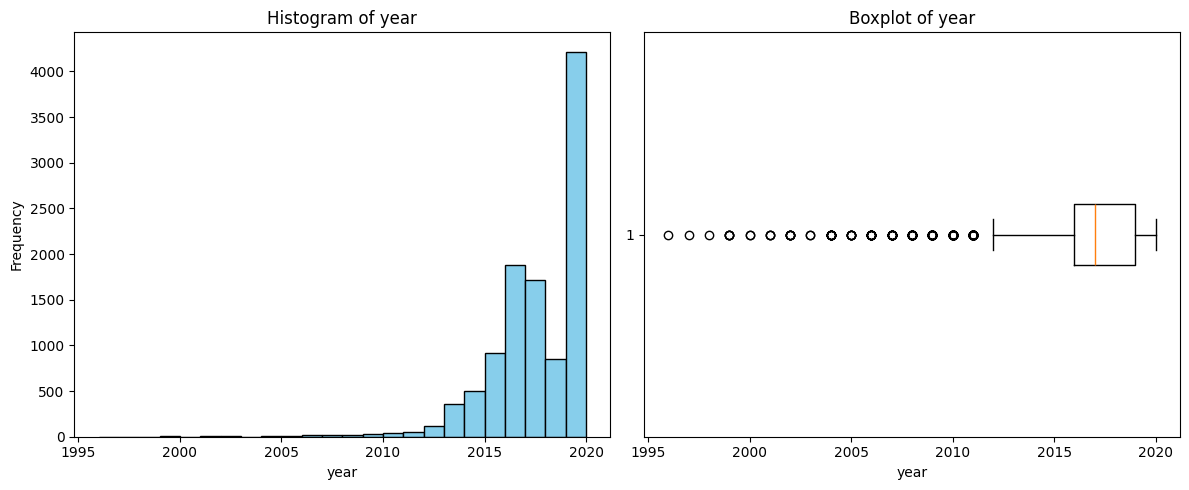

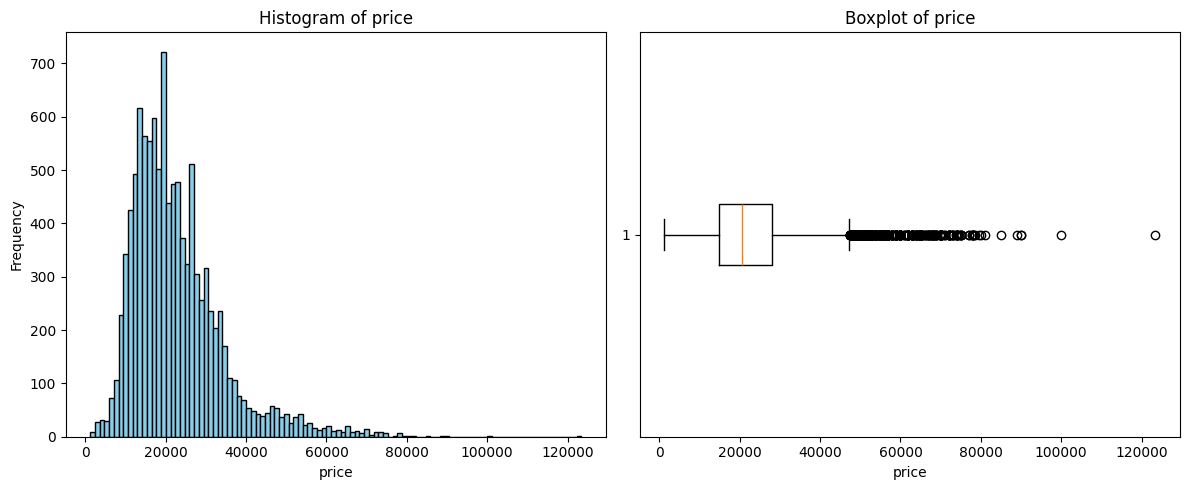

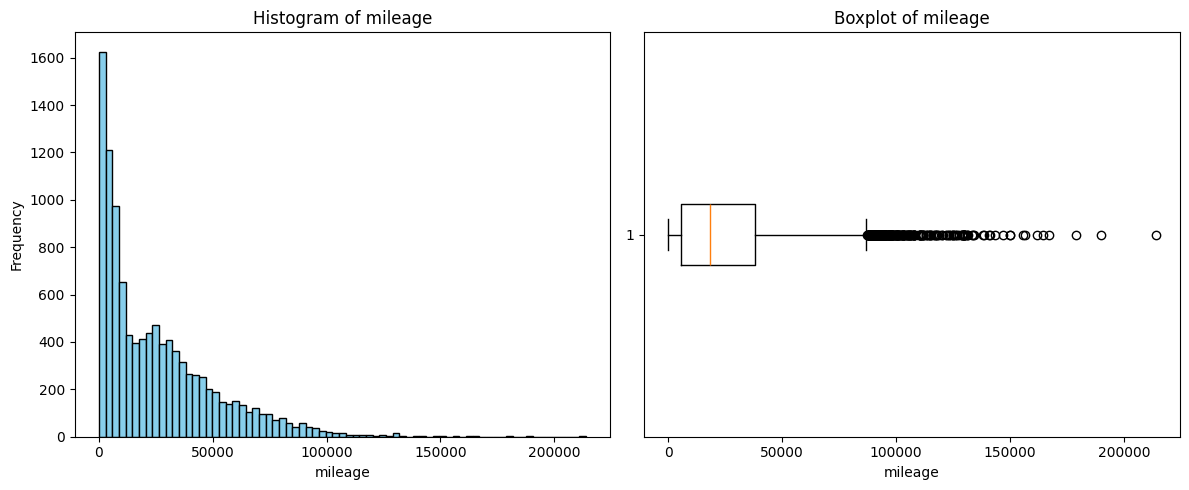

In [5]:
for column_to_histogram in dataset.select_dtypes(include=['float64','int64']).columns[:-3]:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(dataset[column_to_histogram].dropna(), bins='fd', color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column_to_histogram}')
    plt.xlabel(column_to_histogram)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.boxplot(dataset[column_to_histogram].dropna(), vert=False)
    plt.title(f'Boxplot of {column_to_histogram}')
    plt.xlabel(column_to_histogram)

    plt.tight_layout()
    plt.show()

As we can see, all the features have some outliers, especially "price" and "mileage". Both have a right-skewed distribution, showing that most cars are priced lower and have lower mileage, with a few expensive cars and high-mileage vehicles.

Looking to the year feature, we can see that most cars were registered between 2015 and 2020, with fewer cars from earlier years.

Let's check the correlation between these features to undesrstand if any of them can be predicted based on the others.

In [7]:
correlation_matrix = dataset[['year','price','mileage']].corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

,year,price,mileage
year,1.000000,0.623756,-0.774382
price,0.623756,1.000000,-0.605397
mileage,-0.774382,-0.605397,1.000000


**Conclusions:** The price and year have a moderate correlation (0.63), indicating that newer cars tend to be more expensive. Mileage has a weak negative correlation with price (-0.35), suggesting that cars with higher mileage are generally cheaper, but the relationship is not very strong. Overall, while there are some correlations, they are not strong enough to predict one feature solely based on another.

In [39]:
encoders = {}

for categorical_column in dataset.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset[categorical_column] = le.fit_transform(dataset[categorical_column].astype(str))
    encoders[categorical_column] = le

correlation_matrix_encoded = dataset.corr()
correlation_matrix_encoded.style.background_gradient(cmap='coolwarm')

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
model,1.000000,0.076053,0.467866,-0.014013,-0.084811,-0.086900,0.228871,0.009599,0.251913
year,0.076053,1.000000,0.623756,0.264386,-0.774382,0.139643,0.025200,-0.071762,-0.026337
price,0.467866,0.623756,1.000000,0.212334,-0.605397,0.106889,0.263484,-0.204882,0.460196
transmission,-0.014013,0.264386,0.212334,1.000000,-0.291822,0.081514,0.075657,-0.144984,0.035770
mileage,-0.084811,-0.774382,-0.605397,-0.291822,1.000000,-0.242534,-0.170747,0.118609,-0.002540
fuelType,-0.086900,0.139643,0.106889,0.081514,-0.242534,1.000000,0.291733,-0.172322,-0.049112
tax,0.228871,0.025200,0.263484,0.075657,-0.170747,0.291733,1.000000,-0.351798,0.429616
mpg,0.009599,-0.071762,-0.204882,-0.144984,0.118609,-0.172322,-0.351798,1.000000,-0.399844
engineSize,0.251913,-0.026337,0.460196,0.035770,-0.002540,-0.049112,0.429616,-0.399844,1.000000


**Conclusion:** the higher correlation is between price and year, which makes sense since the age of the car tends to influence its price. Mileage shows a weak negative correlation with price, suggesting that while higher mileage may lead to a lower price, it is not a strong predictor on its own.

Let's move on the random forest model creation.

# Random Forest Model Creation

**Goal:** we want to predict the car price based on its features.

**Obs:** the year column means the car's manufacturing year, not the sales year. So we are not able to create a time series model, just estimate current market value based on the car's features.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop(columns=['price']),
    dataset['price'],
    test_size=0.2,
    random_state=42
)

In [17]:
regressor = RandomForestRegressor(n_estimators=500, random_state=0, oob_score=True, n_jobs=-1)
regressor.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [31]:
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions = regressor.predict(X_test)

rmse = root_mean_squared_error(y_test, predictions)
print(f'Root mean Squared Error: {rmse}')

r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.946248152401568
Root mean Squared Error: 2694.935828933938
R-squared: 0.9438373052156148


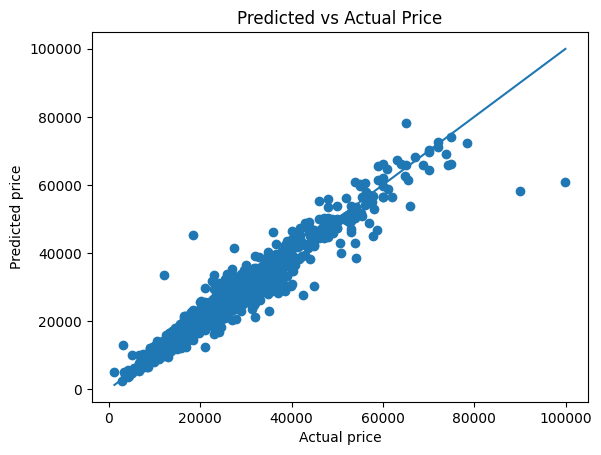

In [22]:
y_true = y_test
y_pred = predictions

plt.figure()
plt.scatter(y_true, y_pred)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()])
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Predicted vs Actual Price")
plt.show()

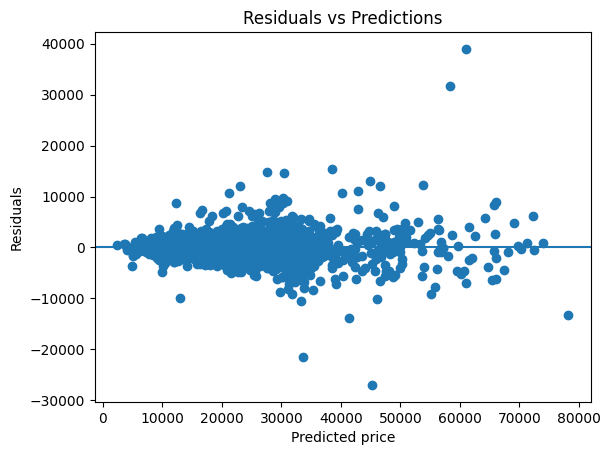

In [23]:
residuals = y_true - y_pred

plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0)
plt.xlabel("Predicted price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.show()


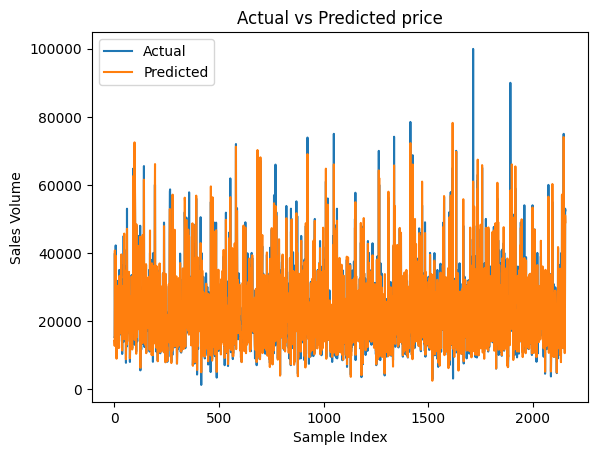

In [24]:
plt.figure()
plt.plot(y_true.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Sales Volume")
plt.title("Actual vs Predicted price")
plt.legend()
plt.show()


**Conclusion:**
- The model achieved an R-squared of 0.94, indicating that it explains 94% of the variance in car prices based on the features used, that is a very good result. We could check in the 'Predicted vs Actual' plot that the predicted prices closely follow the actual prices, further confirming the model's accuracy.
- Besides that, to higher prices, the residuals are more spread out, indicating that the model's predictions are less accurate for more expensive cars. This pattern suggests that while the model performs well overall, it may struggle to capture the nuances of higher-priced vehicles.
- This model fail is expected based on two facts: first, there are a few high-priced cars in the dataset, making it harder for the model to learn their patterns. Second, when the algorithm is generating the bootstrap datasets, these high-priced cars may not be included in some of them, preventing the trees to classify high-priced cars correctly.

## Grid Search for hyperparameter tuning

In [28]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
    'min_impurity_decrease': [0.0, 0.01, 0.1]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters: {'criterion': 'squared_error', 'max_depth': None, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Score: 0.9439716150995506


**Conclusion:** the performance increase was very small, aproximately 0.01 on R² score, indicating that the default hyperparameters were already quite effective for this dataset.

# Save the model

In [40]:
import joblib

model_package = {
    'model': best_rf,
    'encoders': encoders,
    'features': X_train.columns.tolist()
}

joblib.dump(model_package, 'bmw_price_model.pkl')

['bmw_price_model.pkl']